In [1]:
from config import *
from functions import *

from types import SimpleNamespace

# plotting
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable

# math
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import trapz, cumtrapz
from scipy.fft import fftn, fftfreq, fftshift
from scipy.signal.windows import blackman
from scipy.optimize import curve_fit, minimize, leastsq
from scipy.signal import welch
from scipy.integrate import odeint

# cosmology
import const


In [14]:
temp = 1e4
b_turb = 1.0
dx = 10 * const.pc
Macc = 1e1 * const.M_sol / const.Myr
cs = np.sqrt(const.k_B * temp / const.m_p)

M0 = 1e7 * const.M_sol
R0 = 100 * const.pc
V0 = 4/3 * np.pi * R0**3
rho0 = M0 / V0
tff0 = np.sqrt(3*np.pi / (32 * const.G * rho0))
t_res = tff0 * (1 - (dx / R0)**(3/2))
eta = 1.

def dMdt(M, t, vel_turb):
    Mcl, Mstar = M
    V = V0 * (1 - np.minimum(t, t_res) / tff0)**2
    rho = Mcl / V
    eps_sf = calc_eps_sf2(rho, 3/2 * vel_turb**2, temp, dx, b_turb=b_turb)
    dMstardt = eps_sf / tff0 * Mcl
    dMcldt = -(1 + eta) * dMstardt
    return np.array([dMcldt, dMstardt])


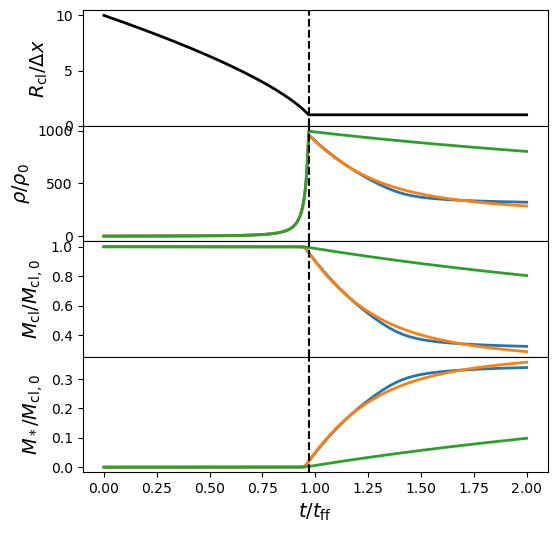

In [19]:
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(6, 6))
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

vel_turb_list = np.array([1, 4, 100]) * const.km
color_list = ["C0", "C1", "C2"]

# cmap = mpl.colormaps['jet']
# norm = LogNorm(0.5, 200)
# color_list = cmap(norm(vel_turb_list/const.km))

# sm = ScalarMappable(norm, cmap=cmap)
# cax = axs[3].inset_axes([1, 0, 0.075, 4])
# cbar = plt.colorbar(sm, cax=cax)
# cbar.set_label(r'$v_{\rm turb}$ [${\rm km}$]', fontsize=14)
# cbar.set_ticks(vel_turb_list/const.km)
# cbar.set_ticklabels(["1", "2", "5", "10", "20", "50", "100"])

t = np.linspace(0, 2*tff0, 2**12)
R = R0 * (1 - np.minimum(t, t_res) / tff0)**(2/3)
axs[0].plot(t / tff0, R / dx, lw=2, color='black')

for i, vel_turb in enumerate(vel_turb_list):
    
    Mcl, Mstar = odeint(dMdt, [M0, const.M_sol], t, args=(vel_turb,)).T
    Mcl[Mcl < 0] = 0
    V = V0 * (1 - np.minimum(t, t_res) / tff0)**2
    rho = Mcl / V
    
    axs[1].plot(t / tff0, rho / rho0, lw=2, color=color_list[i])
    axs[2].plot(t / tff0, Mcl / M0, lw=2, color=color_list[i])
    axs[3].plot(t / tff0, Mstar / M0, lw=2, color=color_list[i])
    
axs[0].set_ylabel(r'$R_{\rm cl}/\Delta x$', fontsize=14)
axs[1].set_ylabel(r'$\rho/\rho_0$', fontsize=14)
axs[2].set_ylabel(r'$M_{\rm cl}/M_{\rm cl,0}$', fontsize=14)
axs[3].set_ylabel(r'$M_*/M_{\rm cl,0}}$', fontsize=14)
axs[3].set_xlabel(r'$t/t_{\rm ff}$', fontsize=14)

axs[0].set_ylim(0, None)
axs[0].axvline(x=(t_res / tff0), color='black', linestyle='--')
axs[1].axvline(x=(t_res / tff0), color='black', linestyle='--')
axs[2].axvline(x=(t_res / tff0), color='black', linestyle='--')
axs[3].axvline(x=(t_res / tff0), color='black', linestyle='--')
    
#plt.plot(t / tff0, Mstar / M0, lw=2)
